In [1]:
#madgraph
from phase_space_generator.flat_phase_space_generator import FlatInvertiblePhasespace
from processes.all_processes import Matrix_1_epem_mummup
from model.parameters import ModelParameters, ParamCard

#autodiff stuff
import jax
from jax import random
from jax.config import config
config.update('jax_enable_x64', True)
key = random.PRNGKey(0)

#numpy & friends
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize

/Users/lukasheinrich/.pyenv/versions/2.7.15/lib/python2.7/site-packages/jax/lib/xla_bridge.py:118: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [10]:
process = Matrix_1_epem_mummup()
active_model = ModelParameters(None)
external_masses = process.get_external_masses(active_model)
E_cm = 90.0

ps_generator = FlatInvertiblePhasespace(
    external_masses[0], external_masses[1],
    beam_Es = (E_cm/2.,E_cm/2.),
    beam_types=(0,0)
)


def get_final_state(rv):
    point = ps_generator.generateKinematics(E_cm,rv)[0]
    return jax.numpy.asarray(
        point.to_array()[-2:]
    )

def matrix_element(c,random_variables):
    PS_point, jacobian = ps_generator.generateKinematics(E_cm, random_variables)
    
    final_state = get_final_state(random_variables)
    
    _Z_mass = c
    _pc = ParamCard()
    _pc.set_block_entry("mass", 23, _Z_mass) #9.118800e+01
    _active_model_params = ModelParameters(_pc).params
    return final_state,process.smatrix(PS_point, _active_model_params)

def log_surrogate(obseved_state,final_state):
    return jax.numpy.sum(jax.scipy.stats.norm.logpdf(obseved_state,final_state,0.5))

def logpdf(observed,parameter):
    final,pdf = matrix_element(90.0,jax.numpy.asarray(parameter))
    return log_surrogate(observed,final) + jax.numpy.log(pdf)

In [25]:
def get_nll(observed):
    def nll(p):
        return -logpdf(observed,p) 

    v_and_g = jax.jit(jax.value_and_grad(nll))

    def objective(p):
        v,g = v_and_g(p)
        return np.asarray(v),np.asarray(g)
    return objective
    
key,subkey = jax.random.split(key)
smear = jax.random.normal(subkey,(2,4))*0.2

fs = get_final_state([0.3,0.4])
objective = get_nll(
    fs[::1,:] + smear
)

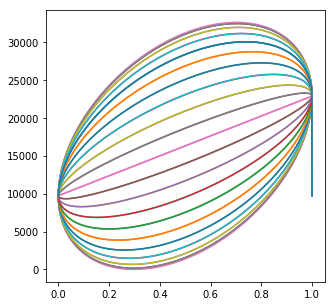

In [26]:
x = np.linspace(0,1,1001)
for x2 in np.linspace(0,1,41):
    y1 = np.asarray([objective([xx%1,x2])[0] for xx in x])
    plt.plot(x,y1)
plt.gcf().set_size_inches(5,5)

In [28]:
r = scipy.optimize.minimize(
    objective,
    np.asarray([0.2,0.6]),
    jac = True,
    method = 'SLSQP',
    bounds = [(0.0,1.0),(0.0,1.0)]
)
print(r)
bestfit = r.x

     fun: 2.004009902259047
     jac: array([-0.33952897, -0.11714169])
 message: 'Optimization terminated successfully.'
    nfev: 15
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.29845923, 0.39978841])
